# 🗂️ Dataset Exploration

In this notebook, you can explore the custom CelebA subset we'll use for training all the models in this class. Feel free to play around with it and change it however you'd like.

**Note:** You should be able to use this notebook with CPU only machines.

If you are using VSCode and you do not see your venv in the kernel options, first activate your venv in your terminal and run 

'''

uv run --active python -m ipykernel install --user --name cmu-10799 --display-name "Python (cmu-10799)"

'''

In VS Code:
- Command Palette → Python: Select Interpreter → pick .venv-(your env)/bin/python
- In the notebook → Select Kernel → pick .venv-(your env) or Python (cmu-10799-cpu)

In [6]:
import sys
sys.path.insert(0, '..')

import os
# This allows multiple copies of OpenMP to exist (safe for local dev/notebooks)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Set style
plt.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the Dataset

We use a curated CelebA subset from HuggingFace Hub: `electronickale/cmu-10799-celeba64-subset`

The images are already preprocessed to 64x64 resolution.

In [7]:
from src.data import create_dataloader, unnormalize

# Option 1: Load from local directory (if you've already downloaded)
# First download with: python download_dataset.py --output_dir YOUR_PATH
# Then uncomment the following to use this option:
# dataloader = create_dataloader(
#     root='YOUR_PATH',
#     split='train',
#     image_size=64,
#     batch_size=64,
#     num_workers=0,  # Set to 0 for notebooks
#     augment=False,  # Disable augmentation for exploration
#     from_hub=False,
# )

# Option 2: Load directly from HuggingFace Hub (requires 'datasets' package)
# Uncomment the following to use this option:
dataloader = create_dataloader(
    split='train',
    image_size=64,
    batch_size=64,
    num_workers=0,
    augment=False,
    from_hub=True,
    repo_name='electronickale/cmu-10799-celeba64-subset',
)

print(f"Dataset size: {len(dataloader.dataset):,} images")
print(f"Batches: {len(dataloader):,}")

Attempt to use cached dataset from: ./data/celeba-subset
⬇ Downloading dataset from HuggingFace Hub: electronickale/cmu-10799-celeba64-subset
  (This may take a few minutes on first run)
Using HuggingFace cache directory: ./data/celeba-subset
Loaded 63715 images from train split
Dataset size: 63,715 images
Batches: 995


Now it is upon you to decide how you would like to explore the dataset. I would recommend first visualize a grid of samples, and go from there.

/Users/amanchulawala/Library/CloudStorage/GoogleDrive-aman.chulawala@gmail.com/My Drive/CMU/10-799/cmu-10799-diffusion/.venv-cpu/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


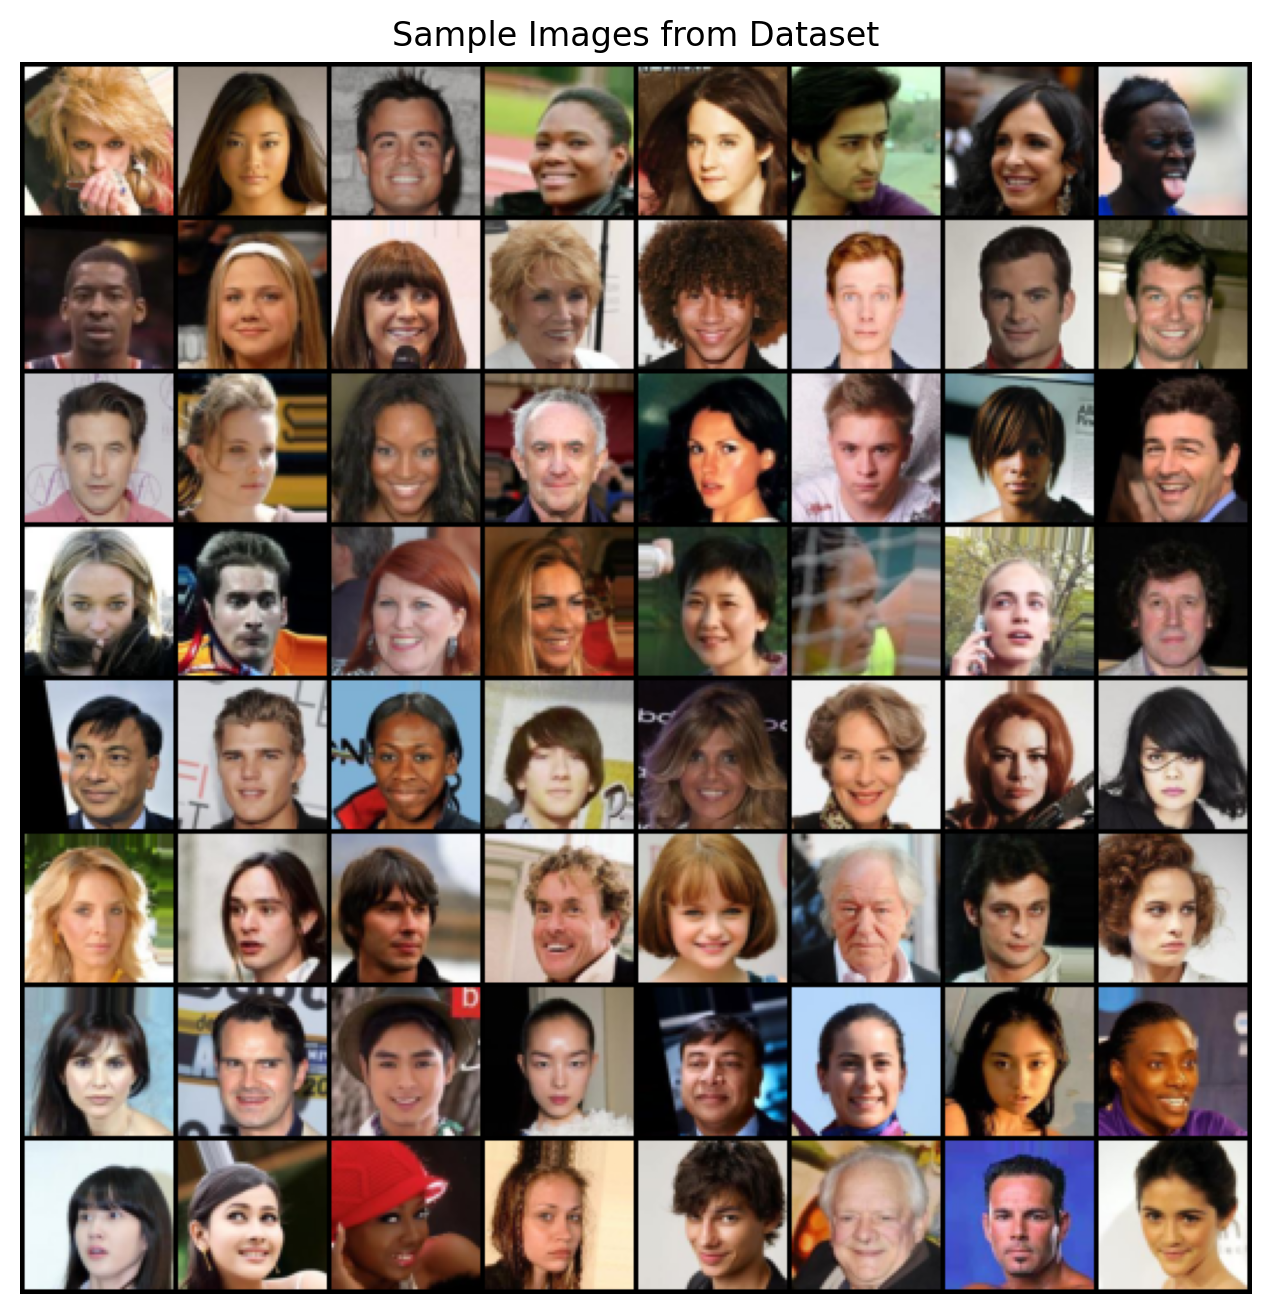

In [3]:
# Visualize some samples
batch = next(iter(dataloader))

# Handle cases where dataloader returns (images, labels) or just images
if isinstance(batch, (list, tuple)):
    images = batch[0]
else:
    images = batch

unnormalized_images = unnormalize(images)

grid_img = make_grid(unnormalized_images, nrow=8, padding=2)

plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.title('Sample Images from Dataset')
plt.show()

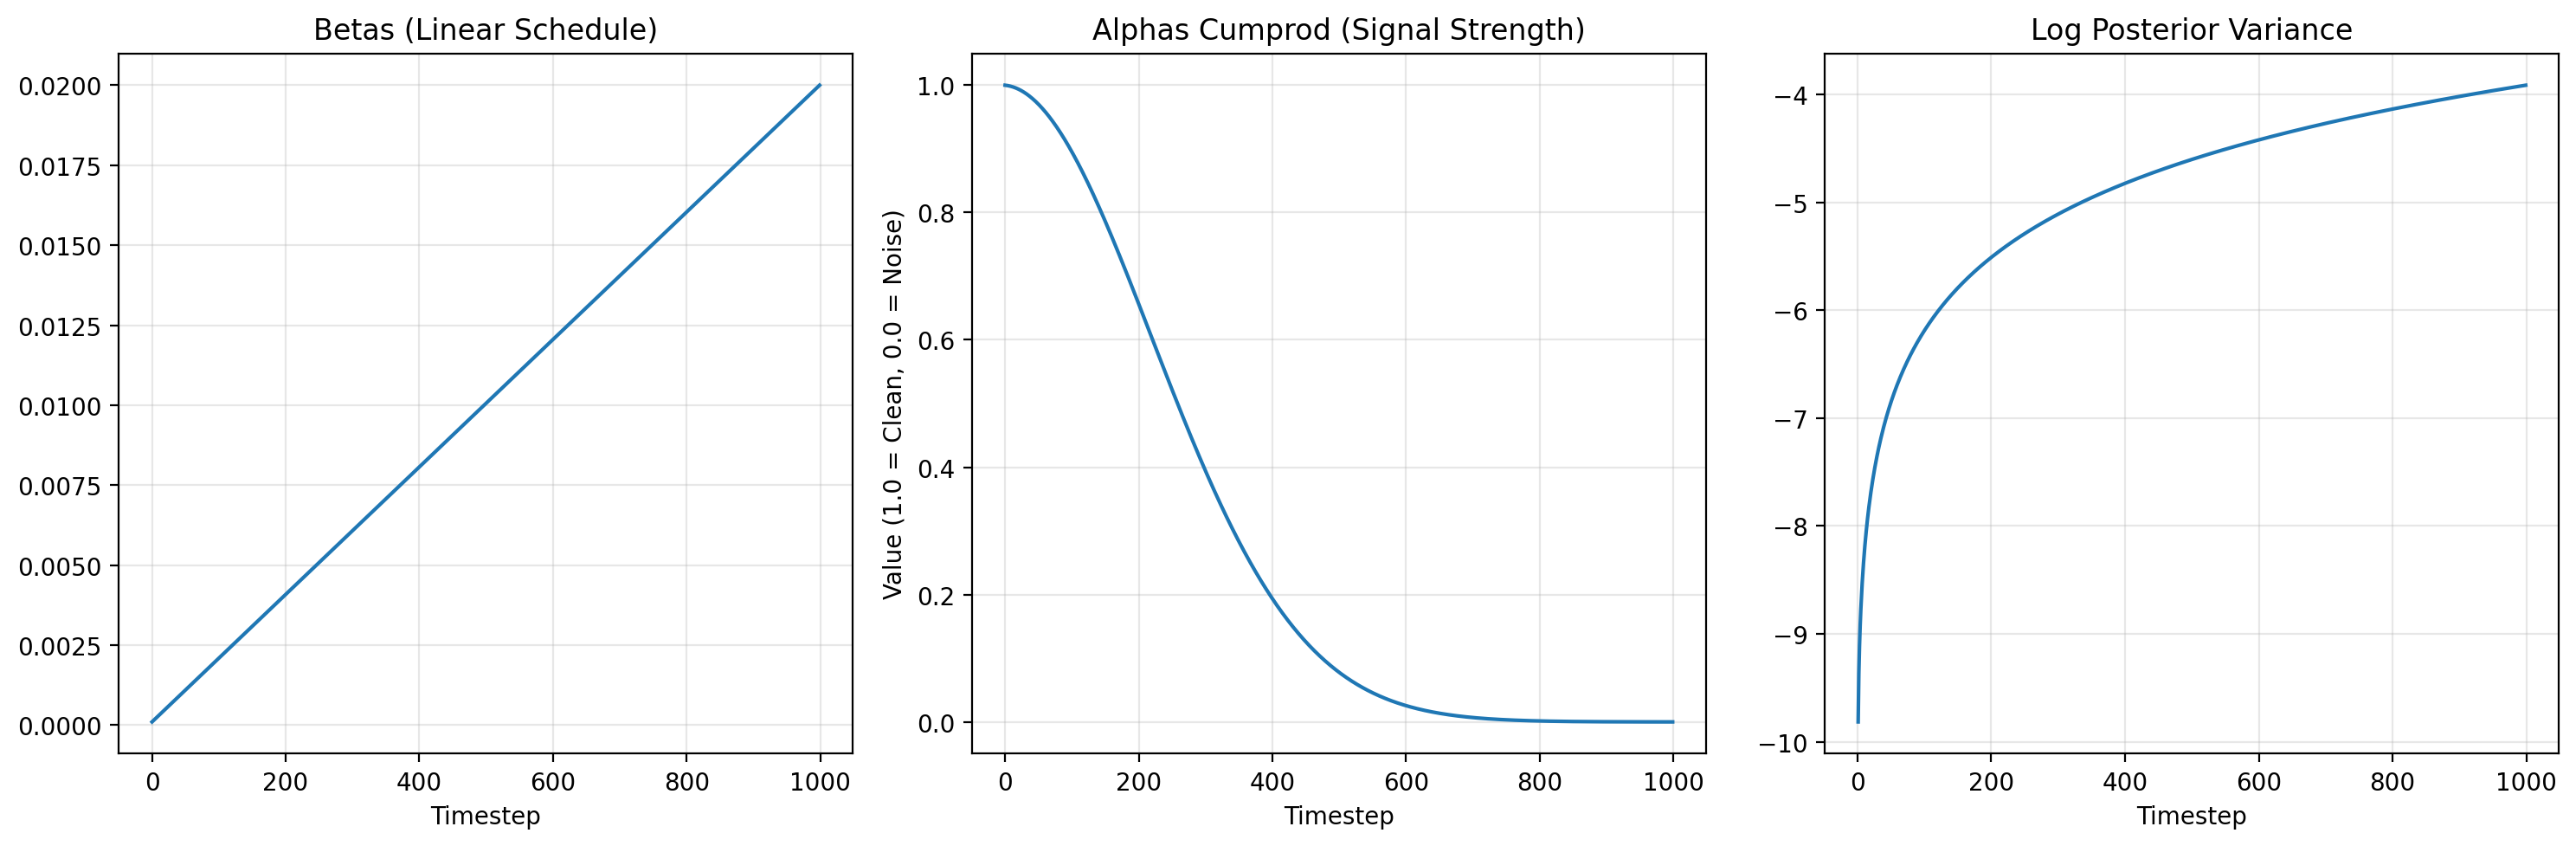

In [4]:
from src.methods.ddpm import DDPM
from src.models.unet import UNet

# Initialize with the "Gold Standard" parameters
model = UNet(in_channels=3, out_channels=3, base_channels=64)
ddpm = DDPM(
    model=model, 
    device="cpu", 
    num_timesteps=1000, 
    beta_start=0.0001, 
    beta_end=0.02
)

# Plot Schedules
plt.figure(figsize=(15, 5))

# 1. Betas (Variance)
plt.subplot(1, 3, 1)
plt.plot(ddpm.betas.cpu())
plt.title("Betas (Linear Schedule)")
plt.xlabel("Timestep")
plt.grid(True, alpha=0.3)

# 2. Alphas Cumprod (Signal Retention)
plt.subplot(1, 3, 2)
plt.plot(ddpm.alphas_cumprod.cpu())
plt.title("Alphas Cumprod (Signal Strength)")
plt.xlabel("Timestep")
plt.ylabel("Value (1.0 = Clean, 0.0 = Noise)")
plt.grid(True, alpha=0.3)

# 3. Posterior Variance (Log scale)
plt.subplot(1, 3, 3)
# We usually look at log variance to check stability near t=0
plt.plot(torch.log(ddpm.posterior_variance.cpu()).numpy())
plt.title("Log Posterior Variance")
plt.xlabel("Timestep")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/Users/amanchulawala/Library/CloudStorage/GoogleDrive-aman.chulawala@gmail.com/My Drive/CMU/10-799/cmu-10799-diffusion/.venv-cpu/lib/python3.13/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


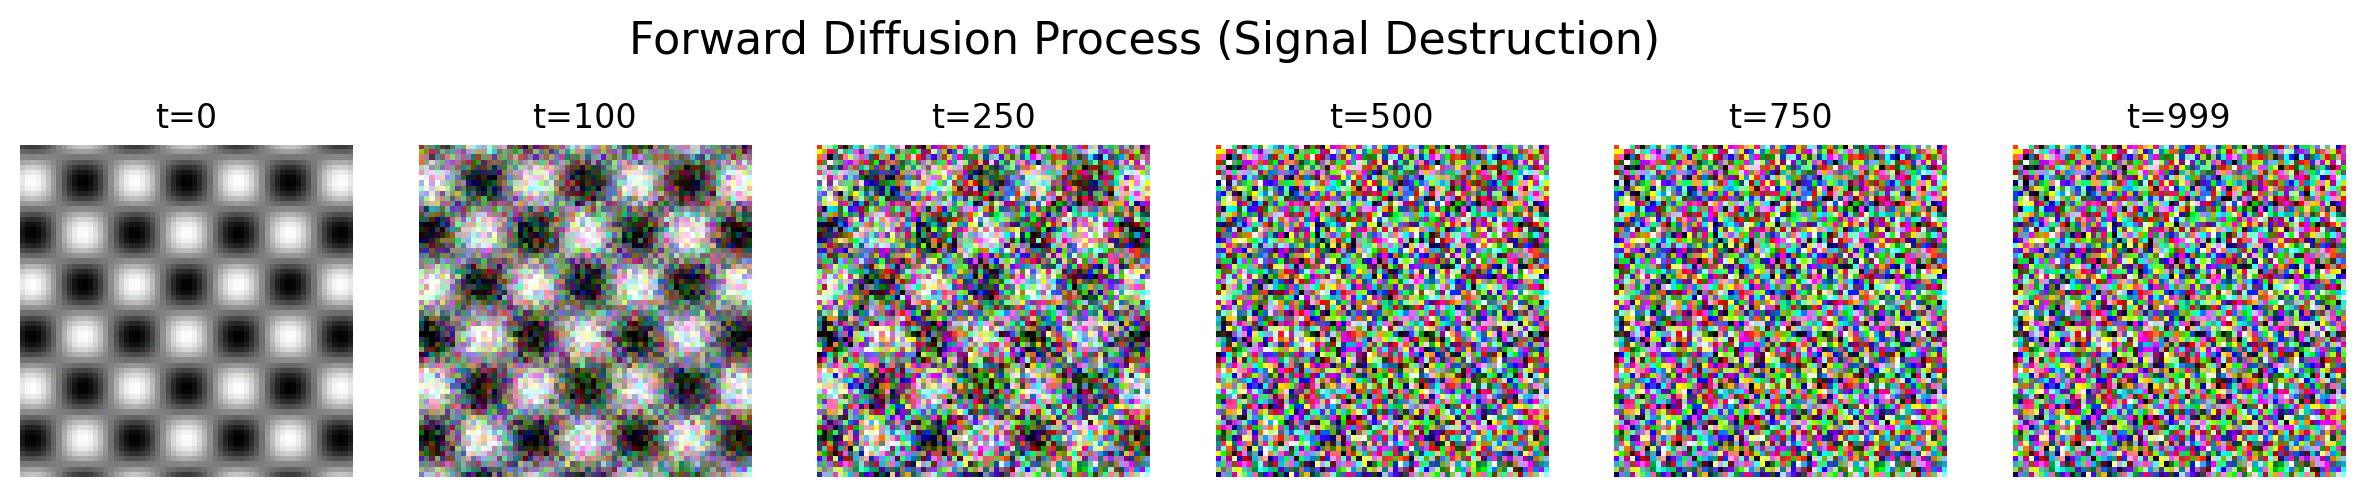

In [5]:
import torchvision

# 1. Load a real image (or create a pattern)
# If you don't have the dataset downloaded yet, we create a dummy "Pattern" image
# A simple gradient pattern is better than random noise for checking diffusion
img_size = 64
x, y = torch.meshgrid(torch.linspace(-1, 1, img_size), torch.linspace(-1, 1, img_size))
pattern = torch.sin(x*10) * torch.cos(y*10) # Checkerboard-ish wave
x_0 = pattern.unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1) # (1, 3, 64, 64)

# 2. Define steps to visualize
viz_steps = [0, 100, 250, 500, 750, 999]

plt.figure(figsize=(15, 3))

for i, t_idx in enumerate(viz_steps):
    t = torch.tensor([t_idx])
    
    # Generate fixed noise for consistency
    torch.manual_seed(42) 
    noise = torch.randn_like(x_0)
    
    # Apply forward process
    x_t = ddpm.forward_process(x_0, t, noise=noise)
    
    # Helper to convert Tensor [-1, 1] -> Numpy [0, 1] for plotting
    img_disp = x_t[0].permute(1, 2, 0).detach().cpu().numpy()
    img_disp = (img_disp + 1) / 2
    img_disp = np.clip(img_disp, 0, 1)
    
    plt.subplot(1, 6, i+1)
    plt.imshow(img_disp)
    plt.title(f"t={t_idx}")
    plt.axis("off")

plt.suptitle("Forward Diffusion Process (Signal Destruction)", fontsize=16)
plt.show()

In [12]:
#Load the dataset into a pandas dataframe directly from HuggingFace Hub
import pandas as pd
from datasets import load_dataset
dataset = load_dataset("electronickale/cmu-10799-celeba64-subset", split="train")
df = pd.DataFrame(dataset)
df.head()

Generating train split:   0%|          | 0/63715 [00:00<?, ? examples/s]

,image,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,000002.png,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,000004.png,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,000007.png,1,0,1,1,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,000008.png,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,000011.png,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [16]:
# Use this dataframe to find attributes that are zero for all images
# For example, checking if 'Eyeglasses' attribute is zero for all images
list_attributes = df.columns.tolist()
list_attributes = list_attributes[2:]
print(list_attributes)
print(len(list_attributes))

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
40


In [17]:
for attr in list_attributes:
    if df[attr].sum() == 0:
        print(f"Attribute '{attr}' is zero for all images.")

Attribute 'Blurry' is zero for all images.
Attribute 'Eyeglasses' is zero for all images.
Attribute 'Heavy_Makeup' is zero for all images.
Attribute 'Wearing_Hat' is zero for all images.
